In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import re
from datetime import datetime
import os

from tensorboard.plugins.hparams import api as hp

from sklearn.metrics import confusion_matrix
import seaborn as sns

import datetime as dt

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

import math
import pandas as pd
import keras

## Fashion MNIST

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

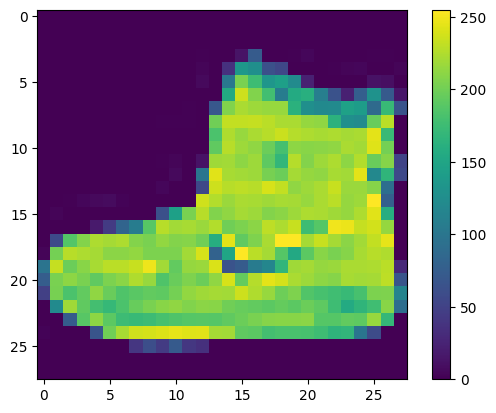

In [5]:
plt.figure()
plt.imshow(fashion_train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the training set and the testing set be preprocessed in the same way:

In [7]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

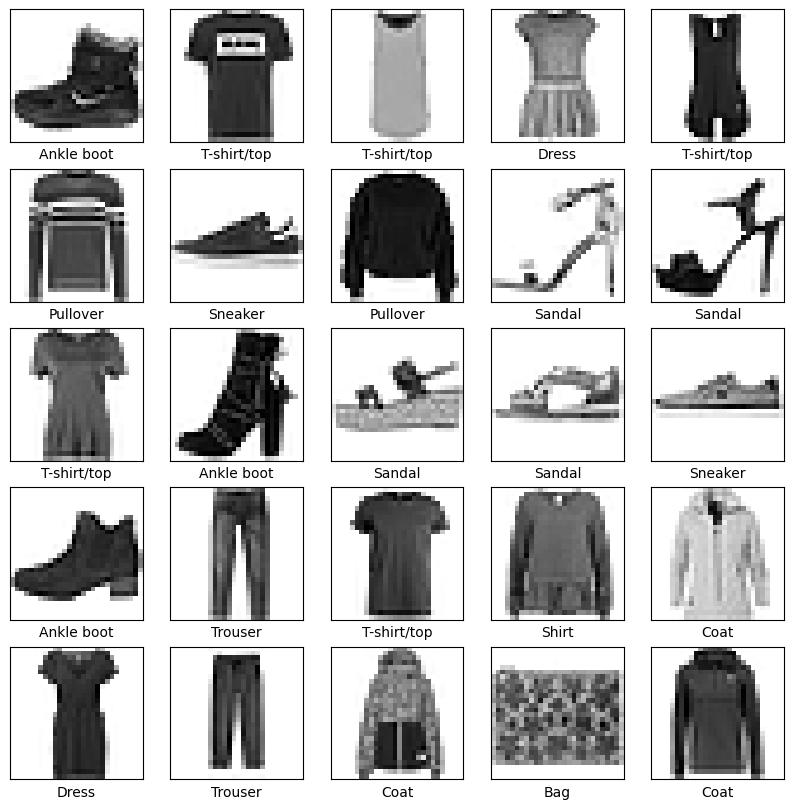

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[fashion_train_labels[i]])
plt.show()

In [8]:
batch_size = 32
num_classes = 10
epochs = 2

row_hidden = 64
col_hidden = 64

In [34]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
# x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
# x1 = tf.keras.layers.LSTM(64, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
# x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
# x2 = tf.keras.layers.LSTM(64, name='LSTM_right', use_bias=False)(x2)

# # Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

concatenated = tf.keras.layers.GlobalMaxPooling1D(data_format=None, keepdims=False)(concatenated)

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 28, 28)]             0         []                            
                                                                                                  
 permute_9 (Permute)         (None, 28, 28)               0         ['input_10[0][0]']            
                                                                                                  
 conv1d_36 (Conv1D)          (None, 28, 64)               5440      ['input_10[0][0]']            
                                                                                                  
 conv1d_38 (Conv1D)          (None, 28, 64)               5440      ['permute_9[0][0]']           
                                                                                            

In [35]:
# Input layer
input_layer = tf.keras.Input(shape=(28, 28))

# Permute the dimensions for column-wise processing
permuted_input = tf.keras.layers.Permute((2, 1))(input_layer)

# First branch with two 1D convolutional layers followed by a bidirectional LSTM
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_layer)
x1 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x1)
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x1)
x1 = tf.keras.layers.LSTM(64, name='LSTM_left', use_bias=False)(x1)

# Second branch with permuted input, two 1D convolutional layers, and a bidirectional LSTM
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(permuted_input)
x2 = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x2)
x2 = tf.keras.layers.LSTM(64, name='LSTM_right', use_bias=False)(x2)

# Concatenate the outputs of the two branches
concatenated = tf.keras.layers.Concatenate()([x1, x2])

# Apply dropout
dropout = tf.keras.layers.Dropout(0.2)(concatenated)

# Output layer
output_layer = tf.keras.layers.Dense(10, activation='softmax')(dropout)

# Create the model
model_fashion_lstm = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_fashion_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_fashion_lstm.summary()

In [36]:
(fashion_train_labels).shape


(60000,)

In [37]:
model_fashion_lstm.fit(fashion_train_images, fashion_train_labels, epochs=4, batch_size=batch_size)

Epoch 1/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5508 - accuracy: 0.8071
Epoch 2/4
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3729 - accuracy: 0.8663
Epoch 3/4
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3333 - accuracy: 0.8796
Epoch 4/4
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3088 - accuracy: 0.8885


In [38]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

313/313 [==============================] - 0s 1ms/step
0.892


In [10]:
model_fashion_lstm = load_model('../model/Fashion_LSTM___Date_Time_2024_04_16__16_19_56___Loss_0.3800537884235382___Accuracy_0.8614000082015991.keras')

In [11]:
LSTM_right_layer = model_fashion_lstm.get_layer('LSTM_right')
LSTM_left_layer = model_fashion_lstm.get_layer('LSTM_left')

original_weights_right = model_fashion_lstm.get_layer('LSTM_right').get_weights()
original_weights_left = model_fashion_lstm.get_layer('LSTM_left').get_weights()

313/313 [==============================] - 3s 7ms/step
0.8614


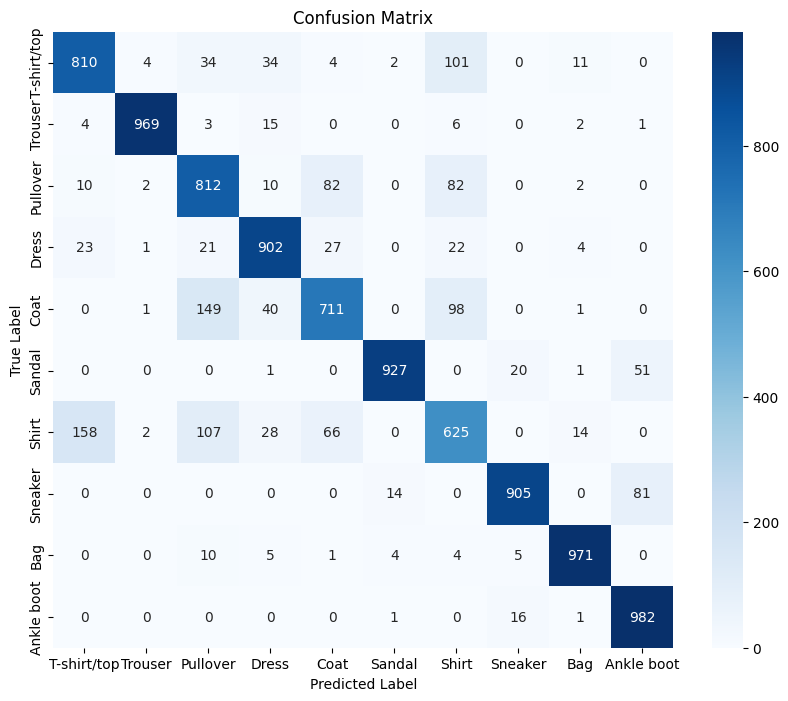

In [12]:
# Predict the classes of the test images
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy = accuracy_score(fashion_test_labels, predicted_classes)
print(accuracy)

# Generate the confusion matrix
cm = confusion_matrix(fashion_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import sys
sys.path.append('/Users/justin/Desktop/Year 4/FYP/Code/main')
from iterative_approximation.Algorithm1 import *

import statistics

from iterative_approximation.Algorithm2StepPruning import *

import itertools
from utils.generate_groupings import *
import matplotlib.cm as cm

from utils.load_layer_weights_from_txt import *
from utils.save_layer_weight_to_txt import *

In [16]:
def extract_weight_array(layer):
    kernel, recurrent_kernel = layer.get_weights()

    I = np.hstack([kernel[:, :layer.units].T,recurrent_kernel[:, :layer.units].T])
    F = np.hstack([kernel[:, layer.units:2*layer.units].T,recurrent_kernel[:, layer.units:2*layer.units].T])
    O = np.hstack([kernel[:, 2*layer.units:3*layer.units].T,recurrent_kernel[:, 2*layer.units:3*layer.units].T])
    C = np.hstack([kernel[:, 3*layer.units:].T,recurrent_kernel[:, 3*layer.units:].T])
    return [I,F,O,C]


In [17]:
def set_layer_weight(layer,original_layer,weight_array):

    input_len = original_layer[0].shape[0]
    
    approximated_kernel = np.hstack([weight_array[0][:,:input_len].T,weight_array[1][:,:input_len].T,weight_array[2][:,:input_len].T,weight_array[3][:,:input_len].T])

    approximated_recurrent_kernel = np.hstack([weight_array[0][:,input_len:].T,weight_array[1][:,input_len:].T,weight_array[2][:,input_len:].T,weight_array[3][:,input_len:].T])

    approximated_weight = [approximated_kernel,approximated_recurrent_kernel]
    
    layer.set_weights(approximated_weight)


In [18]:
predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
accuracy_baseline = accuracy_score(fashion_test_labels, predicted_classes)
accuracy_baseline

313/313 [==============================] - 2s 6ms/step


0.8614

In [239]:
def generate_pairs(R):
    # Define the possible values for Tc
    Tc_values = [2, 4, 8, 16, 32, 64]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = R // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64]:
                valid_pairs.append([Tc, NZc])


    # Return the list of valid pairs
    return valid_pairs

In [238]:
def generate_pairs2(C):
    # Define the possible values for Tc
    Tc_values = [2, 8, 16, 32, 64, 192]

    # Initialize an empty list to store the valid pairs
    valid_pairs = []

    # Iterate over each possible value of Tc
    for Tc in Tc_values:
        # Calculate the maximum possible NZc based on V and Tc
        max_NZc = C // Tc

        # Iterate over possible values of NZc from 1 to max_NZc
        for NZc in range(math.ceil(max_NZc/2), max_NZc + 1):
            if Tc == 2 and (NZc % 8 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 4 and (NZc % 4 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc == 8 and (NZc % 2 == 0):
                valid_pairs.append([Tc, NZc])
            elif Tc in [16, 32, 64, 192]:
                valid_pairs.append([Tc, NZc])

    # Return the list of valid pairs
    return valid_pairs

# Example usage
C = 192
valid_pairs_C = generate_pairs2(C)
print(valid_pairs_C)

[[2, 48], [2, 56], [2, 64], [2, 72], [2, 80], [2, 88], [2, 96], [8, 12], [8, 14], [8, 16], [8, 18], [8, 20], [8, 22], [8, 24], [16, 6], [16, 7], [16, 8], [16, 9], [16, 10], [16, 11], [16, 12], [32, 3], [32, 4], [32, 5], [32, 6], [64, 2], [64, 3], [192, 1]]


In [240]:
R = 64
valid_pairs_R = generate_pairs(R)

C = 192
valid_pairs_C = generate_pairs2(C)

In [242]:
def roofline_model_baseline(clock_frequency,bandwidth,precision,N,R,C,Tr,Tc):
    Nops = N*(4*(R*C + R*(C-1)) + 24*R)

    Ncycles = max(R/Tr, C/Tc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    memory_footprint = N * 4 * (R * C) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [62]:
def roofline_model_single(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [51]:
def roofline_model_stack4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(Nsteps*(2*NZc*Tc + 1 + 8*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [61]:
def roofline_model_group4(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [60]:
def roofline_model_hybrid(clock_frequency,bandwidth,precision,N,R,C,NZr,NZc,Tr,Tc,Nsteps,memory_footprint):
    Nops = N*(4*Nsteps*(2*NZc*Tc + 1 + 2*NZr*Tr) + 24*R)

    Ncycles = max(Nsteps*NZr, Nsteps*NZc, 7*R/Tr)

    inout = N * (C + 2*R) * precision

    CTC = Nops/(inout + memory_footprint)*8 # per bytes

    CP = Nops/(Ncycles)*clock_frequency/1000 # MHz

    AttPerf = min(CTC*bandwidth,CP)

    Texe = Nops/AttPerf/1000000000 # (Ops) / (GOps/s)

    return Nops,Ncycles,CTC,CP,AttPerf,Texe

In [285]:
def design_space_exploration_baseline(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    valid_pairs_R = [2,4,8,16,32,64]
    valid_pairs_C = [2,4,8,16,32,64]

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_baseline(clock_frequency,bandwidth,32,2,R,C,pair_R,pair_C)
                        
            results.append({
                'Tr': pair_R,
                'Tc': pair_C,
                'Accuracy (%)': baseline_accuracy*100,
                'MSE': 0,
                'Nsteps': 'N/A',
                'Memory Footprint (byte)': 2*4*R*C*32,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })

    result = pd.DataFrame(results)

    return result


In [59]:
def design_space_exploration_single(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step1()
                W2.iterative_approximation_step1()

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 30:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_single(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [58]:
def design_space_exploration_stack4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'weight', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1_approximated = W1.iterative_approximation_step3_norm('spec')
                W2_approximated = W2.iterative_approximation_step3_norm('spec')

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_weight() + W2.average_mse_weight()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1_approximated)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2_approximated)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_stack4(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_weight() + W2.average_mse_weight()) / 2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [57]:
def design_space_exploration_group4(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.iterative_approximation_step2()
                W2.iterative_approximation_step2()

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_group4(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [377]:
def design_space_exploration_hybrid(baseline_accuracy,accuracy_loss,mse_threshold,clock_frequency,bandwidth,strategy,norm):
    accuracy_threshold = baseline_accuracy - accuracy_loss

    model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
    model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    LSTM_right_weight_array = extract_weight_array(LSTM_right_layer)
    LSTM_left_weight_array = extract_weight_array(LSTM_left_layer)

    # cross gate: right LSTM
    # cross gate: left LSTM
    W = [LSTM_right_weight_array[0],LSTM_right_weight_array[1],LSTM_right_weight_array[2],LSTM_right_weight_array[3]]
    WW = [LSTM_left_weight_array[0],LSTM_left_weight_array[1],LSTM_left_weight_array[2],LSTM_left_weight_array[3]]

    valid_pairs_R = generate_pairs(R)
    valid_pairs_C = generate_pairs2(C)

    results = []
    
    for pair_R in valid_pairs_R:
        for pair_C in valid_pairs_C:
            # Initialize W1 and W2 with the pruning parameters
            W1 = WeightArrayStepPruning(W, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])
            W2 = WeightArrayStepPruning(WW, 'array', 0.001, pair_R[1], pair_C[1], pair_R[0], pair_C[0])

            W_MSE = 0.01

            # Refine weights until MSE is within the threshold
            while W_MSE > mse_threshold or accuracy < accuracy_threshold:
                W1.hybrid_iterative_approximation_step_norm(strategy,norm)
                W2.hybrid_iterative_approximation_step_norm(strategy,norm)

                # Recalculate MSE for the new weights
                W_MSE = (W1.average_mse_array() + W2.average_mse_array()) / 2

                if W1.steps > 40:
                    break

                # Evaluate only if necessary
                if W_MSE <= mse_threshold:
                    set_layer_weight(LSTM_right_layer,original_weights_right,W1.current_reconstructed_weight_array)
                    set_layer_weight(LSTM_left_layer,original_weights_left,W2.current_reconstructed_weight_array)
                    predicted_classes = np.argmax(model_fashion_lstm.predict(fashion_test_images), axis=-1)
                    accuracy = accuracy_score(fashion_test_labels, predicted_classes)

            Nops, Ncycles, CTC, CP, AttPerf, Texe = roofline_model_hybrid(clock_frequency,bandwidth,W1.precision,2,64,192,pair_R[1], pair_C[1], pair_R[0], pair_C[0],W1.steps,(W1.memory_footprint_compressed+W2.memory_footprint_compressed))
                        
            results.append({
                'NZr': pair_R[1],
                'NZc': pair_C[1],
                'Tr': pair_R[0],
                'Tc': pair_C[0],
                'Accuracy (%)': accuracy*100,
                'MSE': ((W1.average_mse_array() + W2.average_mse_array())/2),
                'Nsteps': W1.steps,
                'Compressed Memory Footprint (byte)': (W1.memory_footprint_compressed+W2.memory_footprint_compressed)/8,
                'Nops': Nops,
                'Ncycles': Ncycles,
                'CTC (Ops/byte)': CTC,
                'CP (GOps/s)': CP,
                'AttPerf (GOps/s)': AttPerf,
                'Execution Time (s)': Texe
            })
            
            model_fashion_lstm.get_layer('LSTM_right').set_weights(original_weights_right)
            model_fashion_lstm.get_layer('LSTM_left').set_weights(original_weights_left)

    result = pd.DataFrame(results)

    return result


In [19]:
accuracy_baseline

0.8614

In [20]:
clock_frequency = 400 # 400MHz
bandwidth = 10 # 10GB/s

In [286]:
baseline_10GB = design_space_exploration_baseline(accuracy_baseline,0.01,0.005, clock_frequency, bandwidth)

In [287]:
baseline_10GB

,Tr,Tc,Accuracy (%),MSE,Nsteps,Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,2,2,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
1,2,4,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
2,2,8,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
3,2,16,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
4,2,32,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
5,2,64,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004
6,4,2,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004
7,4,4,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004
8,4,8,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004
9,4,16,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004


In [373]:
single_10GB = design_space_exploration_single(accuracy_baseline,0.01,0.005, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


KeyboardInterrupt: 

In [79]:
stack4_10GB = design_space_exploration_stack4(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


In [80]:
stack4_10GB.to_csv('dse_result/stack4_10GB.csv', index=False)

In [81]:
group4_10GB = design_space_exploration_group4(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth)

313/313 [==============================] - 2s 6ms/step


In [82]:
group4_10GB.to_csv('dse_result/group4_10GB.csv', index=False)

In [83]:
hybrid1_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,1,'spec')

313/313 [==============================] - 2s 7ms/step


In [84]:
hybrid1_10GB.to_csv('dse_result/hybrid1_10GB.csv', index=False)

In [86]:
hybrid3_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,3,'fro')

313/313 [==============================] - 2s 6ms/step


In [87]:
hybrid3_10GB.to_csv('dse_result/hybrid3_10GB.csv', index=False)

In [88]:
hybrid6_10GB = design_space_exploration_hybrid(accuracy_baseline,0.01,0.006, clock_frequency, bandwidth,6,'spec')

KeyboardInterrupt: 

In [ ]:
hybrid6_10GB.to_csv('dse_result/hybrid6_10GB.csv', index=False)

In [196]:
single_10GB = pd.read_csv('../dse_result/single_10GB.csv')
stack4_10GB = pd.read_csv('../dse_result/stack4_10GB.csv')
group4_10GB = pd.read_csv('../dse_result/group4_10GB.csv')
hybrid1_10GB = pd.read_csv('../dse_result/hybrid1_10GB.csv')
hybrid3_10GB = pd.read_csv('../dse_result/hybrid3_10GB.csv')

In [29]:
def update_results(df, clock_frequency, bandwidth, computation_roof):
    # Define a helper function to apply to each row
    def update_row(row):
        # Calculate CP (Clock Performance)
        row['CP (GOps/s)'] = (row['Nops'] / row['Ncycles']) * clock_frequency/1000
        
        # Calculate Attainable Performance (AttPerf)
        row['AttPerf (GOps/s)'] = min(row['CTC (Ops/byte)'] * bandwidth, row['CP (GOps/s)'],computation_roof)
        
        # Calculate Execution Time (Texe)
        if row['AttPerf (GOps/s)'] != 0:  # Avoid division by zero
            row['Execution Time (s)'] = row['Nops'] / row['AttPerf (GOps/s)']/1000000000
        else:
            row['Execution Time (s)'] = float('inf')  # Handle division by zero as infinite time
        
        return row

    # Apply the function across the DataFrame
    df = df.apply(update_row, axis=1)
    return df

In [333]:
def cal_dsp_usage_baseline(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr']) +
                           adder_dsp * (result['Tc'] - 1)*result['Tr'] +
                           multiplier_dsp * result['Tc'] *result['Tr']) * 4 * 2
    return result

In [332]:
def cal_dsp_usage(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 4 * 2

    return result

In [331]:
def cal_dsp_usage_stack4(df, adder_dsp, multiplier_dsp, accumulator_dsp):
    result = df.copy()
    # Check if the 'DSP Usage' key does not exist in the dictionary
    if 'DSP Usage' not in result:
        # If it does not exist, initialize 'DSP Usage' to 0 (or any other appropriate default value)
        result['DSP Usage'] = 0

    # Update the 'DSP Usage' key with the specific formula
    result['DSP Usage'] = (accumulator_dsp * (result['Tr'] + 1) +
                           adder_dsp * (result['Tc'] - 1) +
                           multiplier_dsp * 2 * result['Tc']) * 2

    return result

In [30]:
def remove(df, accuracy_baseline, accuracy_loss):
    result = df.copy()

    # Calculate the accuracy threshold
    accuracy = accuracy_baseline*100 - accuracy_loss
    
    # Remove entries from the DataFrame where 'Accuracy (%)' is not greater than the calculated accuracy
    result = result[result['Accuracy (%)'] > accuracy]
    
    return result

In [31]:
def correct_stack4(df, clock_frequency,bandwidth):
    result = df.copy()
    # Compute the 'Ncycles' by using pandas methods that work with Series
    # Calculate each term in a new Series and then take the maximum of all these Series along axis=1
    term1 = 4 * result['Nsteps'] * result['NZr']
    term2 = result['Nsteps'] * result['NZc']
    term3 = 7 * 64 / result['Tr']
    result['Ncycles'] = pd.concat([term1, term2, term3], axis=1).max(axis=1)
    
    # Compute 'CP (GOps/s)'
    result['CP (GOps/s)'] = result['Nops'] / result['Ncycles'] * clock_frequency / 1000  # MHz to GHz conversion for ops/s calculation

    term1 = result['CP (GOps/s)']
    term2 = result['CTC (Ops/byte)'] * bandwidth
    result['AttPerf (GOps/s)'] = pd.concat([term1,term2],axis=1).min(axis=1)

    result['Execution Time (s)'] = result['Nops']/result['AttPerf (GOps/s)']/1000000000
    
    return result

In [32]:
stack4_10GB

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,16,48,2,2,86.22,0.005979,14,25984.00,15644,672.0,0.548066,9.311905,5.480661,0.000003
1,16,56,2,2,85.94,0.005935,13,25792.00,15578,728.0,0.549450,8.559341,5.494498,0.000003
2,16,64,2,2,86.14,0.005915,12,25344.00,15384,768.0,0.551319,8.012500,5.513188,0.000003
3,16,72,2,2,85.75,0.005954,11,24640.00,15062,792.0,0.553750,7.607071,5.537500,0.000003
4,16,80,2,2,85.94,0.005898,11,26048.00,15766,880.0,0.551105,7.166364,5.511046,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,5,64,32,85.22,0.005645,10,33385.00,19732,50.0,0.548950,157.856000,5.489498,0.000004
416,1,6,64,32,85.55,0.005532,9,32350.50,19218,54.0,0.550493,142.355556,5.504934,0.000003
417,1,2,64,64,85.28,0.005728,12,36981.00,21528,24.0,0.544448,358.800000,5.444475,0.000004
418,1,3,64,64,85.55,0.005532,9,32343.75,19218,27.0,0.550600,284.711111,5.505999,0.000003


In [33]:
stack4_10GB_1 = correct_stack4(stack4_10GB,clock_frequency,bandwidth)

,NZr,NZc,Tr,Tc,Accuracy (%),MSE,Nsteps,Compressed Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s)
0,16,48,2,2,86.22,0.005979,14,25984.00,15644,896.0,0.548066,6.983929,5.480661,0.000003
1,16,56,2,2,85.94,0.005935,13,25792.00,15578,832.0,0.549450,7.489423,5.494498,0.000003
2,16,64,2,2,86.14,0.005915,12,25344.00,15384,768.0,0.551319,8.012500,5.513188,0.000003
3,16,72,2,2,85.75,0.005954,11,24640.00,15062,792.0,0.553750,7.607071,5.537500,0.000003
4,16,80,2,2,85.94,0.005898,11,26048.00,15766,880.0,0.551105,7.166364,5.511046,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,1,5,64,32,85.22,0.005645,10,33385.00,19732,50.0,0.548950,157.856000,5.489498,0.000004
416,1,6,64,32,85.55,0.005532,9,32350.50,19218,54.0,0.550493,142.355556,5.504934,0.000003
417,1,2,64,64,85.28,0.005728,12,36981.00,21528,48.0,0.544448,179.400000,5.444475,0.000004
418,1,3,64,64,85.55,0.005532,9,32343.75,19218,36.0,0.550600,213.533333,5.505999,0.000003


In [334]:
baseline_10GB_dsp = cal_dsp_usage_baseline(baseline_10GB,2,2,7)
single_10GB_dsp = cal_dsp_usage(single_10GB, 2, 2, 7)
stack4_10GB_dsp = cal_dsp_usage_stack4(stack4_10GB_1, 2, 2, 7)
group4_10GB_dsp = cal_dsp_usage(group4_10GB, 2, 2, 7)
hybrid1_10GB_dsp = cal_dsp_usage(hybrid1_10GB, 2, 2, 7)
hybrid3_10GB_dsp = cal_dsp_usage(hybrid3_10GB, 2, 2, 7)


# remove entries that do not satisfy accuracy requirement
single_10GB_dsp = remove(single_10GB_dsp, accuracy_baseline,1)
stack4_10GB_dsp = remove(stack4_10GB_dsp, accuracy_baseline,1)
group4_10GB_dsp = remove(group4_10GB_dsp, accuracy_baseline,1)
hybrid1_10GB_dsp = remove(hybrid1_10GB_dsp, accuracy_baseline,1)
hybrid3_10GB_dsp = remove(hybrid3_10GB_dsp, accuracy_baseline,1)

single_10GB_dsp.to_csv('../dse_result/single_10GB_dsp.csv', index=False)
stack4_10GB_dsp.to_csv('../dse_result/stack4_10GB_dsp.csv', index=False)
group4_10GB_dsp.to_csv('../dse_result/group4_10GB_dsp.csv', index=False)
hybrid1_10GB_dsp.to_csv('../dse_result/hybrid1_10GB_dsp.csv', index=False)
hybrid3_10GB_dsp.to_csv('../dse_result/hybrid3_10GB_dsp.csv', index=False)


In [278]:
baseline_10GB_dsp

,Tr,Tc,Accuracy (%),MSE,Nsteps,Memory Footprint (byte),Nops,Ncycles,CTC (Ops/byte),CP (GOps/s),AttPerf (GOps/s),Execution Time (s),DSP Usage
0,2,2,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,208
1,2,4,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,336
2,2,8,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,592
3,2,16,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,1104
4,2,32,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,2128
5,2,64,86.14,0,N/A,3145728,199168,224.0,0.503234,355.657143,5.032342,0.00004,4176
6,4,2,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004,416
7,4,4,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004,672
8,4,8,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004,1184
9,4,16,86.14,0,N/A,3145728,199168,112.0,0.503234,711.314286,5.032342,0.00004,2208


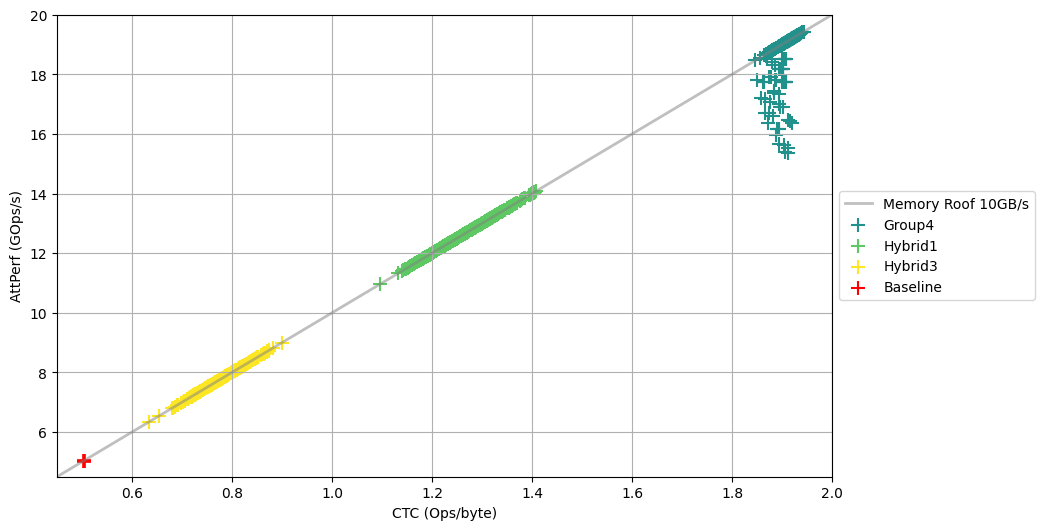

In [381]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.5, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

plt.scatter(baseline_10GB_dsp['CTC (Ops/byte)'], baseline_10GB_dsp['AttPerf (GOps/s)'],
            color='red', marker='+', s=100, label='Baseline')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.xlim([0.45,2])
plt.ylim([4.5,20])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

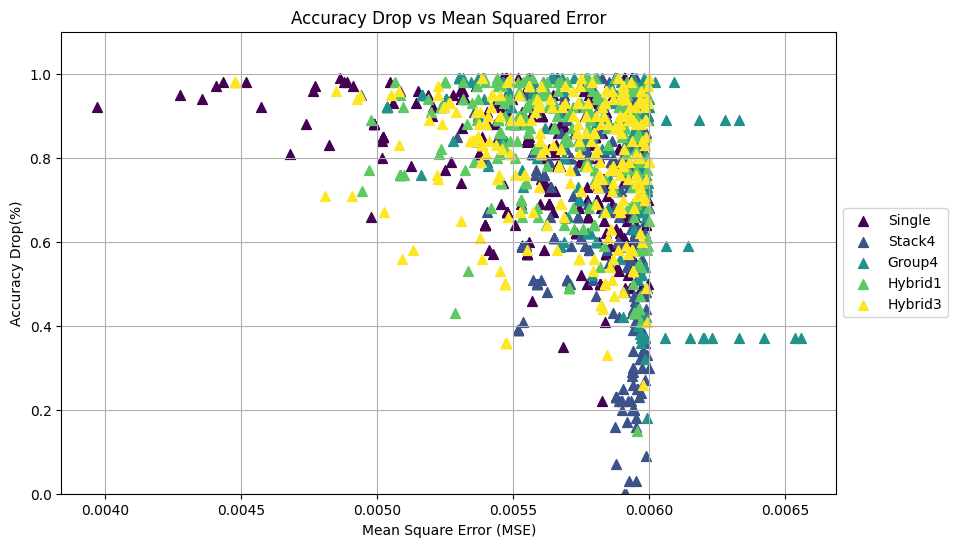

In [336]:
# Assuming you've already imported or defined stack4_10GB and single_10GB

# Plotting
plt.figure(figsize=(10, 6))


plt.scatter(single_10GB_dsp['MSE'], accuracy_baseline*100 - single_10GB_dsp['Accuracy (%)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['MSE'], accuracy_baseline*100 - stack4_10GB_dsp['Accuracy (%)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['MSE'], accuracy_baseline*100 - group4_10GB_dsp['Accuracy (%)'],
            color=colors[2], marker='^', s=50, label='Group4')

plt.scatter(hybrid1_10GB_dsp['MSE'], accuracy_baseline*100 - hybrid1_10GB_dsp['Accuracy (%)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['MSE'], accuracy_baseline*100 - hybrid3_10GB_dsp['Accuracy (%)'],
            color=colors[4], marker='^', s=50, label='Hybrid3')



# Labeling the axes
plt.title('Accuracy Drop vs Mean Squared Error')
plt.xlabel('Mean Square Error (MSE)')
plt.ylabel('Accuracy Drop(%)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.ylim([0,1.1])


# Show the plot
plt.show()

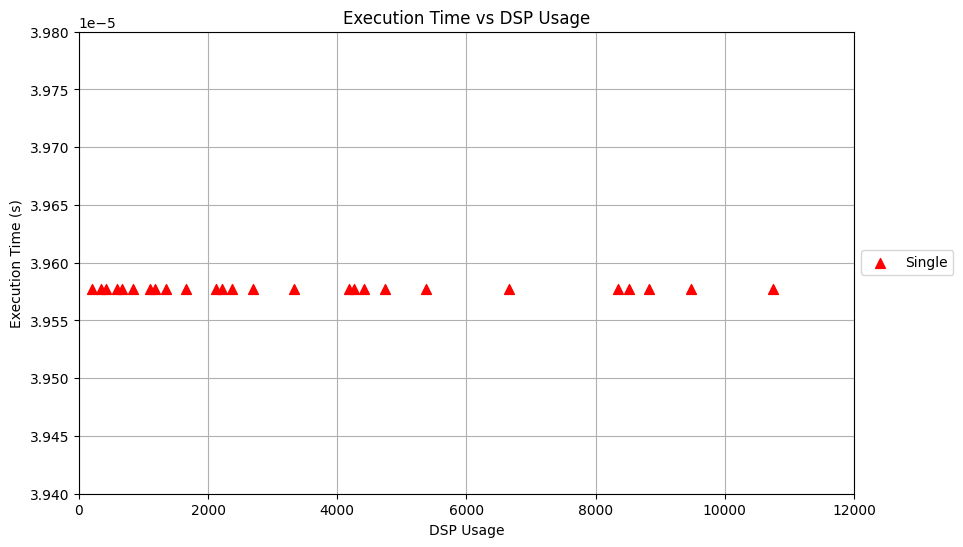

In [374]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(baseline_10GB_dsp['DSP Usage'], baseline_10GB_dsp['Execution Time (s)'],
            color='red', marker='^', s=50, label='Single')


# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([0,12000])
plt.ylim([0.0000394,0.0000398])

plt.grid()

# Show the plot
plt.show()

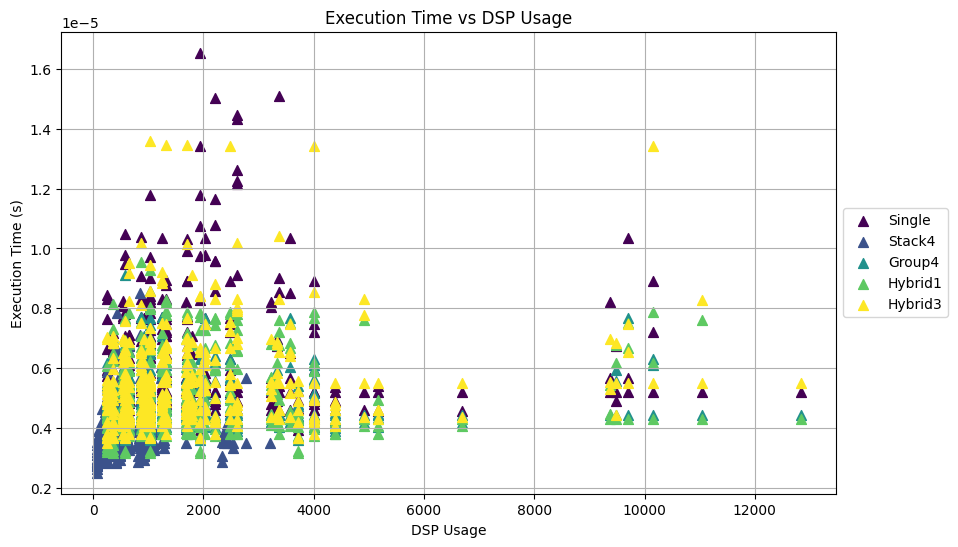

In [337]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['Execution Time (s)'],
            color=colors[0], marker='^', s=50, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=50, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=50, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['Execution Time (s)'],
            color=colors[3], marker='^', s=50, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['Execution Time (s)'],
            color=colors[4], marker='^', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

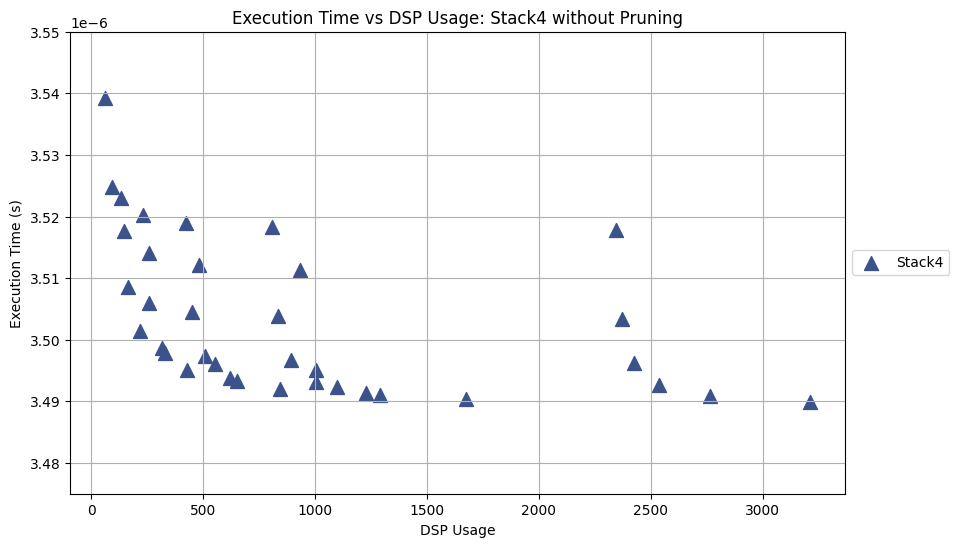

In [338]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

df_stack4 = stack4_10GB_dsp[stack4_10GB_dsp['Nops'] == 19218]

plt.scatter(df_stack4['DSP Usage'], df_stack4['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4')

# Labeling the axes
plt.title('Execution Time vs DSP Usage: Stack4 without Pruning')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.ylim([0.000003475,0.00000355])

# Show the plot
plt.show()

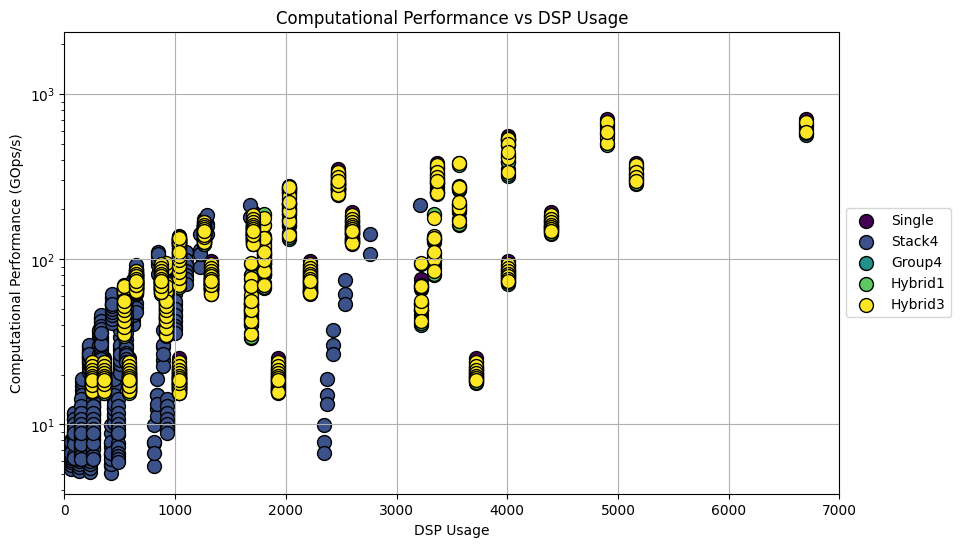

In [339]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['DSP Usage'], single_10GB_dsp['CP (GOps/s)'],
            color=colors[0], marker='o',edgecolors='black', s=100, label='Single')

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['CP (GOps/s)'],
            color=colors[1], marker='o',edgecolors='black', s=100, label='Stack4')

plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['CP (GOps/s)'],
            color=colors[2], marker='o',edgecolors='black', s=100, label='Group4')
            
plt.scatter(hybrid1_10GB_dsp['DSP Usage'], hybrid1_10GB_dsp['CP (GOps/s)'],
            color=colors[3], marker='o',edgecolors='black', s=100, label='Hybrid1')

plt.scatter(hybrid3_10GB_dsp['DSP Usage'], hybrid3_10GB_dsp['CP (GOps/s)'],
            color=colors[4], marker='o',edgecolors='black', s=100, label='Hybrid3')
            

# Labeling the axes
plt.title('Computational Performance vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Computational Performance (GOps/s)')

# Set y-axis to log scale
plt.yscale('log')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()
plt.xlim([0,7000])

# Show the plot
plt.show()

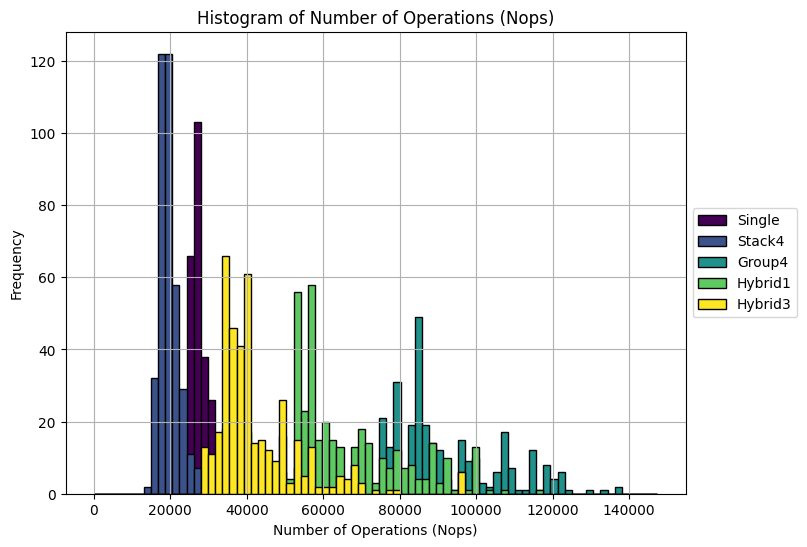

In [340]:
# Plotting the histogram
plt.figure(figsize=(8, 6))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Nops'].max(),
    stack4_10GB_dsp['Nops'].max(),
    group4_10GB_dsp['Nops'].max(),
    hybrid1_10GB_dsp['Nops'].max(),
    hybrid3_10GB_dsp['Nops'].max()
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 80  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')
plt.hist(hybrid1_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[3], edgecolor='black',label='Hybrid1')
plt.hist(hybrid3_10GB_dsp['Nops'], bins=np.arange(0, max_value, bin_size), color=colors[4], edgecolor='black',label='Hybrid3')

# Adding labels and title
plt.xlabel('Number of Operations (Nops)')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Operations (Nops)')

# Show the grid
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

In [123]:
print(f"Single Nops Median: {single_10GB_dsp['Nops'].median()}")
print(f"Stack4 Nops Median: {stack4_10GB_dsp['Nops'].median()}")
print(f"Group4 Nops Median: {group4_10GB_dsp['Nops'].median()}")
print(f"Hybrid1 Nops Median: {hybrid1_10GB_dsp['Nops'].median()}")
print(f"Hybrid3 Nops Median: {hybrid3_10GB_dsp['Nops'].median()}")

Single Nops Median: 27712.0
Stack4 Nops Median: 19221.0
Group4 Nops Median: 86232.0
Hybrid1 Nops Median: 60792.0
Hybrid3 Nops Median: 39784.0


In [124]:
print(f"Single AttPerf (GOps/s) Median: {single_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Stack4 AttPerf (GOps/s) Median: {stack4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Group4 AttPerf (GOps/s) Median: {group4_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid1 AttPerf (GOps/s) Median: {hybrid1_10GB_dsp['AttPerf (GOps/s)'].median()}")
print(f"Hybrid3 AttPerf (GOps/s) Median: {hybrid3_10GB_dsp['AttPerf (GOps/s)'].median()}")

Single AttPerf (GOps/s) Median: 5.296348627946754
Stack4 AttPerf (GOps/s) Median: 5.469741289851934
Group4 AttPerf (GOps/s) Median: 19.12263123502505
Hybrid1 AttPerf (GOps/s) Median: 12.943932636596017
Hybrid3 AttPerf (GOps/s) Median: 7.764167771505775


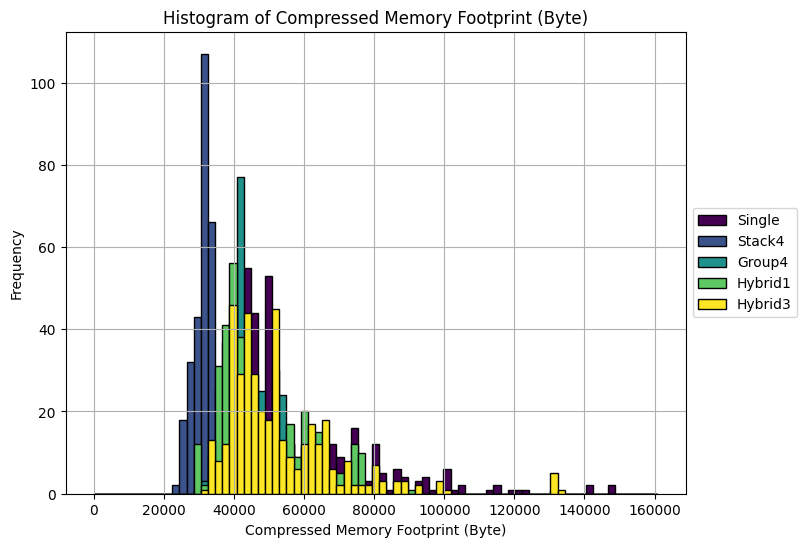

In [199]:
# Plotting the histogram
plt.figure(figsize=(8, 6))  # Set the figure size

colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Determine the maximum value among all datasets to set a reasonable bin size
max_value = max(
    single_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    stack4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    group4_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    hybrid1_10GB_dsp['Compressed Memory Footprint (byte)'].max(),
    hybrid3_10GB_dsp['Compressed Memory Footprint (byte)'].max()
)

# Calculate a reasonable bin size based on the maximum value
bin_size = max_value / 80  # Adjust 30 to the desired number of bins

plt.hist(single_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[0], edgecolor='black',label='Single')
plt.hist(stack4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[1], edgecolor='black',label='Stack4')
plt.hist(group4_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[2], edgecolor='black',label='Group4')
plt.hist(hybrid1_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[3], edgecolor='black',label='Hybrid1')
plt.hist(hybrid3_10GB_dsp['Compressed Memory Footprint (byte)'], bins=np.arange(0, max_value, bin_size), color=colors[4], edgecolor='black',label='Hybrid3')

# Adding labels and title
plt.xlabel('Compressed Memory Footprint (Byte)')
plt.ylabel('Frequency')
plt.title('Histogram of Compressed Memory Footprint (Byte)')

# Show the grid
plt.grid(True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()

In [343]:
baseline_10GB_min = baseline_10GB_dsp[baseline_10GB_dsp['Execution Time (s)'] == baseline_10GB_dsp['Execution Time (s)'].min()].iloc[0]
single_10GB_min = single_10GB_dsp[single_10GB_dsp['Execution Time (s)'] == single_10GB_dsp['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10GB_dsp[stack4_10GB_dsp['Execution Time (s)'] == stack4_10GB_dsp['Execution Time (s)'].min()]
group4_10GB_min = group4_10GB_dsp[group4_10GB_dsp['Execution Time (s)'] == group4_10GB_dsp['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_10GB_dsp[hybrid1_10GB_dsp['Execution Time (s)'] == hybrid1_10GB_dsp['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_10GB_dsp[hybrid3_10GB_dsp['Execution Time (s)'] == hybrid3_10GB_dsp['Execution Time (s)'].min()]


Tr                                  2
Tc                                  2
Accuracy (%)                    86.14
MSE                                 0
Nsteps                            N/A
Memory Footprint (byte)       3145728
Nops                           199168
Ncycles                         224.0
CTC (Ops/byte)               0.503234
CP (GOps/s)                355.657143
AttPerf (GOps/s)             5.032342
Execution Time (s)            0.00004
DSP Usage                         208
Name: 0, dtype: object

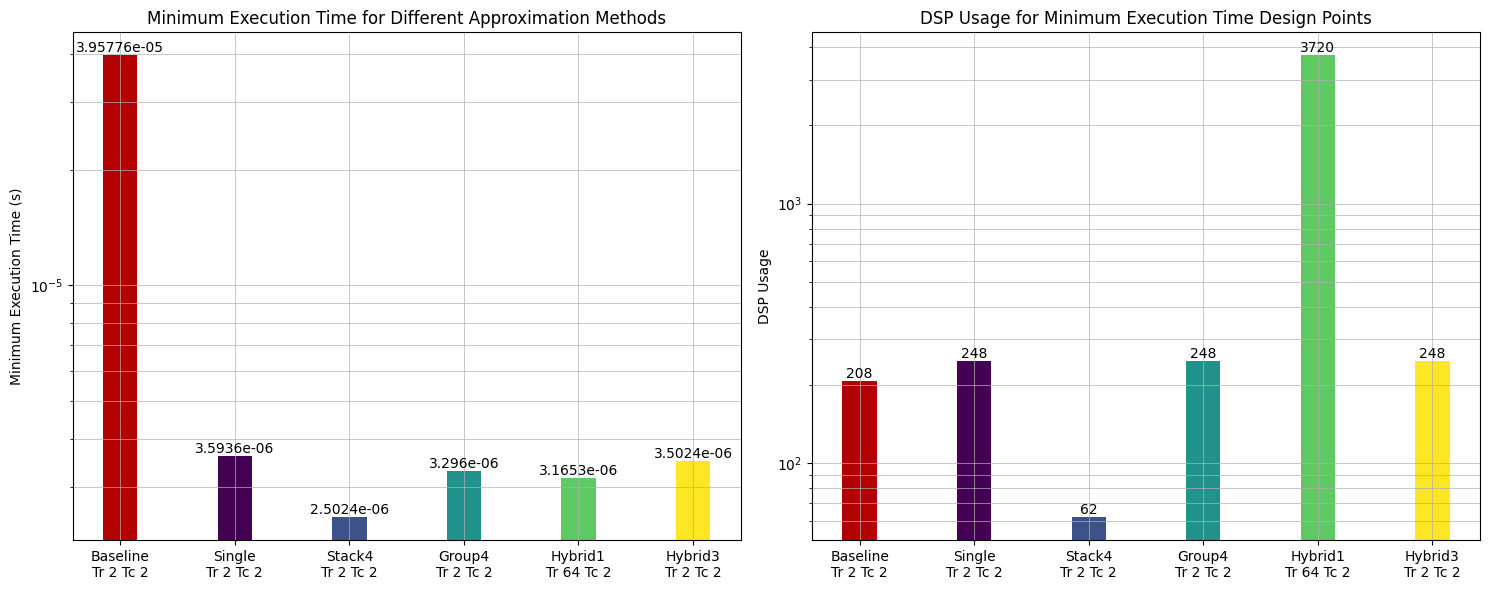

In [342]:
import matplotlib.ticker as ticker

# Prepare the DataFrame for Minimum Execution Time
df_min_values_time = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'Min Execution Time (s)': [
        baseline_10GB_min['Execution Time (s)'],
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
})

# Prepare the DataFrame for DSP Usage
df_min_values_dsp = pd.DataFrame({
    'Dataset': [
        f"Baseline\nTr {baseline_10GB_min['Tr']} Tc {baseline_10GB_min['Tc']}",
        f"Single\nTr {single_10GB_min['Tr'].iloc[0]} Tc {single_10GB_min['Tc'].iloc[0]}",
        f"Stack4\nTr {stack4_10GB_min['Tr'].iloc[0]} Tc {stack4_10GB_min['Tc'].iloc[0]}",
        f"Group4\nTr {group4_10GB_min['Tr'].iloc[0]} Tc {group4_10GB_min['Tc'].iloc[0]}",
        f"Hybrid1\nTr {hybrid1_10GB_min['Tr'].iloc[0]} Tc {hybrid1_10GB_min['Tc'].iloc[0]}",
        f"Hybrid3\nTr {hybrid3_10GB_min['Tr'].iloc[0]} Tc {hybrid3_10GB_min['Tc'].iloc[0]}"
    ],
    'DSP Usage': [
        baseline_10GB_min['DSP Usage'],
        single_10GB_min['DSP Usage'].iloc[0],
        stack4_10GB_min['DSP Usage'].iloc[0],
        group4_10GB_min['DSP Usage'].iloc[0],
        hybrid1_10GB_min['DSP Usage'].iloc[0],
        hybrid3_10GB_min['DSP Usage'].iloc[0]
    ]
})

# Plotting
plt.figure(figsize=(15, 6))  # Bigger figure to accommodate both subplots

# Subplot for Minimum Execution Time
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
colors = [list([0.7, 0, 0])]  # Red color in RGB
vir_colors = plt.cm.viridis(np.linspace(0, 1, 5))
colors.extend(vir_colors)  # Extend the list with viridis colors

bars_time = plt.bar(df_min_values_time['Dataset'], df_min_values_time['Min Execution Time (s)'], color=colors, width=0.3)
for bar in bars_time:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')

plt.ylabel('Minimum Execution Time (s)')
plt.yscale('log')
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks
plt.title('Minimum Execution Time for Different Approximation Methods')


# Subplot for DSP Usage
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
bars_dsp = plt.bar(df_min_values_dsp['Dataset'], df_min_values_dsp['DSP Usage'], color=colors, width=0.3)
for bar in bars_dsp:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.ylabel('DSP Usage')
plt.yscale('log')
# Setting the y-axis to have a minor grid with specific locations
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))
plt.grid(True, which="both", linestyle='-', linewidth=0.5)  # Enable grid for both major and minor ticks

plt.title('DSP Usage for Minimum Execution Time Design Points')

plt.tight_layout()  # Adjust layout
plt.show()



In [365]:
baseline_10GB_min= baseline_10GB_dsp.nsmallest(50, 'Execution Time (s)').iloc[0]
single_10GB_min_5 = single_10GB_dsp.nsmallest(50, 'Execution Time (s)')
stack4_10GB_min_5 = stack4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
group4_10GB_min_5 = group4_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid1_10GB_min_5 = hybrid1_10GB_dsp.nsmallest(50, 'Execution Time (s)')
hybrid3_10GB_min_5 = hybrid3_10GB_dsp.nsmallest(50, 'Execution Time (s)')

stack4_10GB_min_5 = stack4_10GB_min_5[stack4_10GB_min_5['Accuracy (%)']<(accuracy_baseline*100-0.2)]

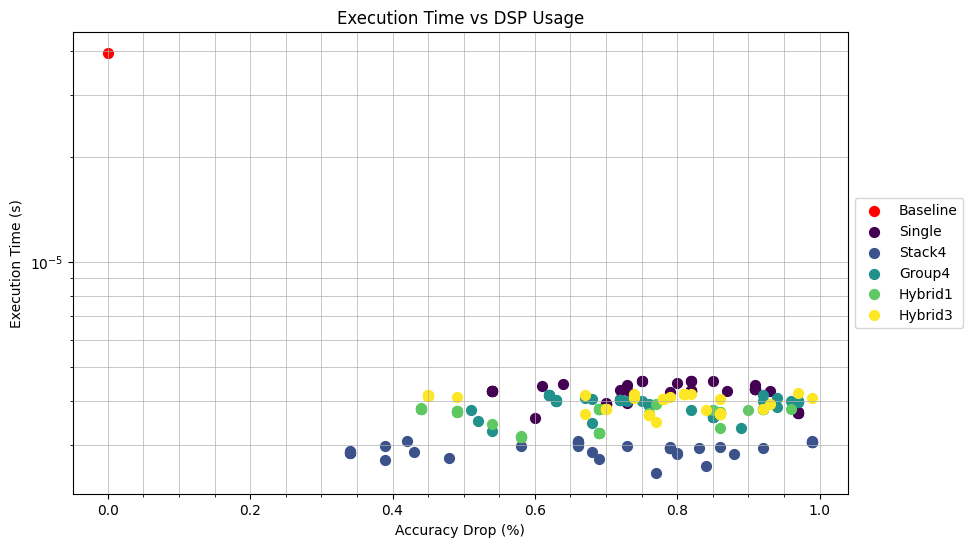

In [366]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(accuracy_baseline*100 - baseline_10GB_min['Accuracy (%)'], baseline_10GB_min['Execution Time (s)'],
            color='red', marker='o', s=50, label='Baseline')

plt.scatter(accuracy_baseline*100 - single_10GB_min_5['Accuracy (%)'], single_10GB_min_5['Execution Time (s)'],
            color=colors[0], marker='o', s=50, label='Single')

plt.scatter(accuracy_baseline*100 - stack4_10GB_min_5['Accuracy (%)'], stack4_10GB_min_5['Execution Time (s)'],
            color=colors[1], marker='o', s=50, label='Stack4')

plt.scatter(accuracy_baseline*100 - group4_10GB_min_5['Accuracy (%)'], group4_10GB_min_5['Execution Time (s)'],
            color=colors[2], marker='o', s=50, label='Group4')
            
plt.scatter(accuracy_baseline*100 - hybrid1_10GB_min_5['Accuracy (%)'], hybrid1_10GB_min_5['Execution Time (s)'],
            color=colors[3], marker='o', s=50, label='Hybrid1')

plt.scatter(accuracy_baseline*100 - hybrid3_10GB_min_5['Accuracy (%)'], hybrid3_10GB_min_5['Execution Time (s)'],
            color=colors[4], marker='o', s=50, label='Hybrid3')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('Accuracy Drop (%)')
plt.ylabel('Execution Time (s)')
# Setting y-axis to logarithmic scale
plt.yscale('log')

# Setting minor locators for the y-axis
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(2, 10), numticks=10))

# Setting minor locators for the x-axis
plt.gca().xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Automatically determine the number of minor intervals

# Enabling grid for both major and minor ticks
plt.grid(True, which="both", linestyle='-', linewidth=0.5, axis='both')  # Enable grid on both axes

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [174]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_10_1825 = update_results(single_10GB_dsp,400,10,16)
stack4_10_1825 = update_results(stack4_10GB_dsp,400,10,16)
group4_10_1825 = update_results(group4_10GB_dsp,400,10,16)
hybrid1_10_1825 = update_results(hybrid1_10GB_dsp,400,10,16)
hybrid3_10_1825 = update_results(hybrid3_10GB_dsp,400,10,16)


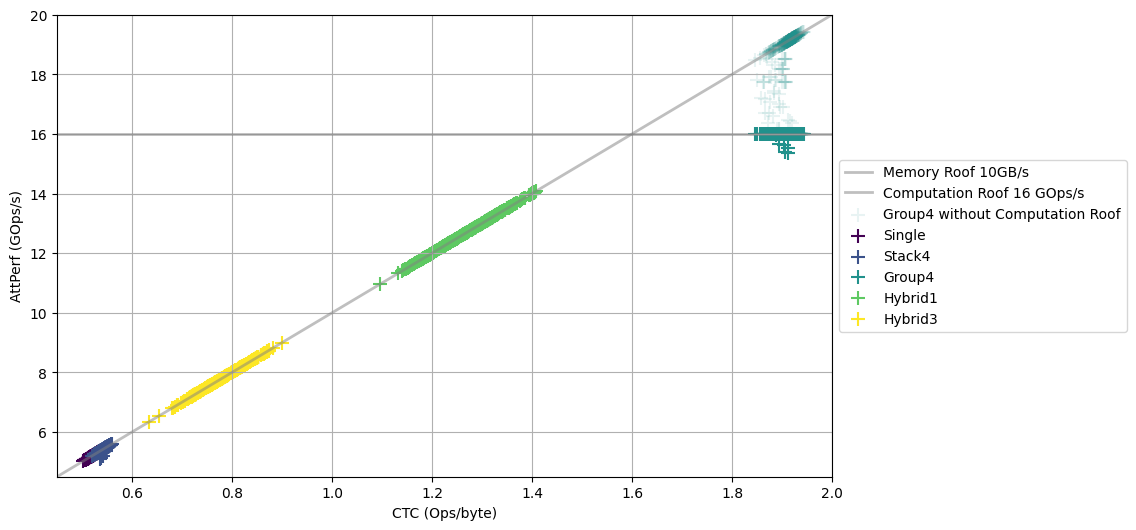

In [179]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.5, linewidth=2)
plt.axhline(y=16, color='gray',alpha=0.5,label='Computation Roof 16 GOps/s', linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4 without Computation Roof', alpha=0.1)

plt.scatter(single_10_1825['CTC (Ops/byte)'], single_10_1825['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_10_1825['CTC (Ops/byte)'], stack4_10_1825['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_10_1825['CTC (Ops/byte)'], group4_10_1825['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_10_1825['CTC (Ops/byte)'], hybrid1_10_1825['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_10_1825['CTC (Ops/byte)'], hybrid3_10_1825['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.ylim([4.5,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

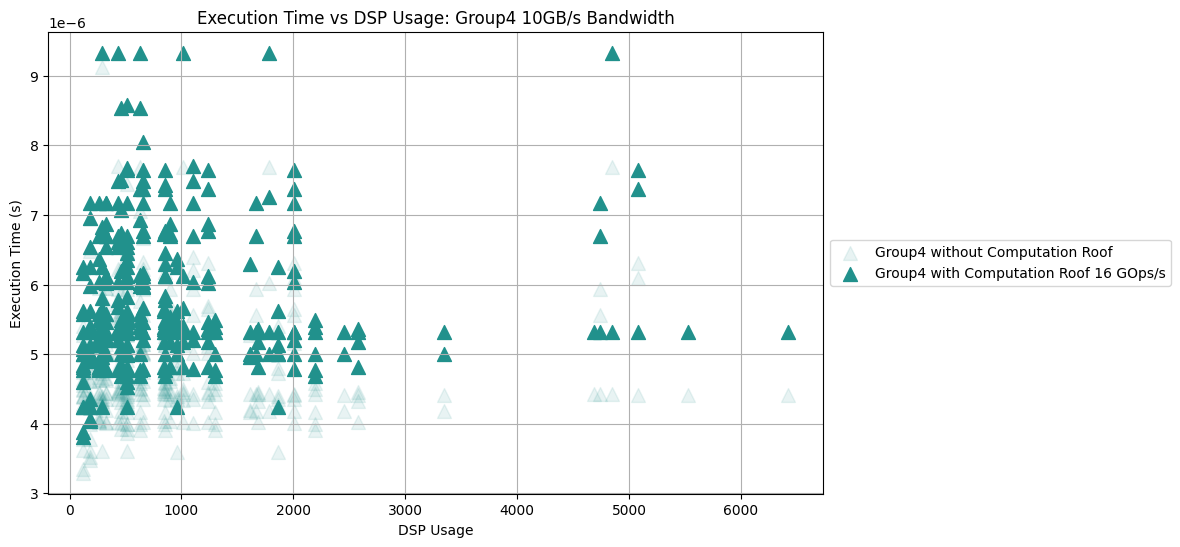

In [146]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))


plt.scatter(group4_10GB_dsp['DSP Usage'], group4_10GB_dsp['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 without Computation Roof ', alpha=0.1)

plt.scatter(group4_10_1825['DSP Usage'], group4_10_1825['Execution Time (s)'],
            color=colors[2], marker='^', s=100, label='Group4 with Computation Roof 16 GOps/s')
            

# Labeling the axes
plt.title('Execution Time vs DSP Usage: Group4 10GB/s Bandwidth')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

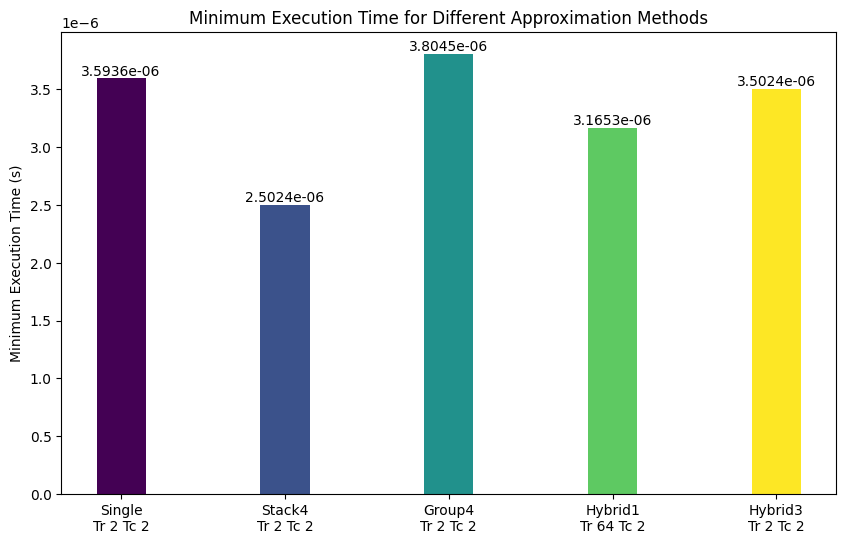

In [234]:
single_10GB_min = single_10_1825[single_10_1825['Execution Time (s)'] == single_10_1825['Execution Time (s)'].min()]
stack4_10GB_min = stack4_10_1825[stack4_10_1825['Execution Time (s)'] == stack4_10_1825['Execution Time (s)'].min()]
group4_10GB_min = group4_10_1825[group4_10_1825['Execution Time (s)'] == group4_10_1825['Execution Time (s)'].min()]
hybrid1_10GB_min = hybrid1_10_1825[hybrid1_10GB_dsp['Execution Time (s)'] == hybrid1_10_1825['Execution Time (s)'].min()]
hybrid3_10GB_min = hybrid3_10_1825[hybrid3_10GB_dsp['Execution Time (s)'] == hybrid3_10_1825['Execution Time (s)'].min()]

# Prepare a summary DataFrame
min_values = {
    'Dataset': [
        f"Single\nTr {int(single_10GB_min['Tr'].iloc[0])} Tc {int(single_10GB_min['Tc'].iloc[0])}",
        f"Stack4\nTr {int(stack4_10GB_min['Tr'].iloc[0])} Tc {int(stack4_10GB_min['Tc'].iloc[0])}",
        f"Group4\nTr {int(group4_10GB_min['Tr'].iloc[0])} Tc {int(group4_10GB_min['Tc'].iloc[0])}",
        f"Hybrid1\nTr {int(hybrid1_10GB_min['Tr'].iloc[0])} Tc {int(hybrid1_10GB_min['Tc'].iloc[0])}",
        f"Hybrid3\nTr {int(hybrid3_10GB_min['Tr'].iloc[0])} Tc {int(hybrid3_10GB_min['Tc'].iloc[0])}"
    ],
    'Min Execution Time (s)': [
        single_10GB_min['Execution Time (s)'].iloc[0],
        stack4_10GB_min['Execution Time (s)'].iloc[0],
        group4_10GB_min['Execution Time (s)'].iloc[0],
        hybrid1_10GB_min['Execution Time (s)'].iloc[0],
        hybrid3_10GB_min['Execution Time (s)'].iloc[0]
    ]
}

df_min_values = pd.DataFrame(min_values)

# Plotting
plt.figure(figsize=(10, 6))

bars = plt.bar(df_min_values['Dataset'], df_min_values['Min Execution Time (s)'], color=colors, width=0.3)

# Adding labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 10), ha='center', va='bottom')  # Adjust `round(yval, 2)` if you need different precision

plt.ylabel('Minimum Execution Time (s)')
plt.title('Minimum Execution Time for Different Approximation Methods')
plt.show()

In [154]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
single_5GB = update_results(single_10GB_dsp,400,5,20)
stack4_5GB = update_results(stack4_10GB_dsp,400,5,20)
group4_5GB = update_results(group4_10GB_dsp,400,5,20)
hybrid1_5GB = update_results(hybrid1_10GB_dsp,400,5,20)
hybrid3_5GB = update_results(hybrid3_10GB_dsp,400,5,20)

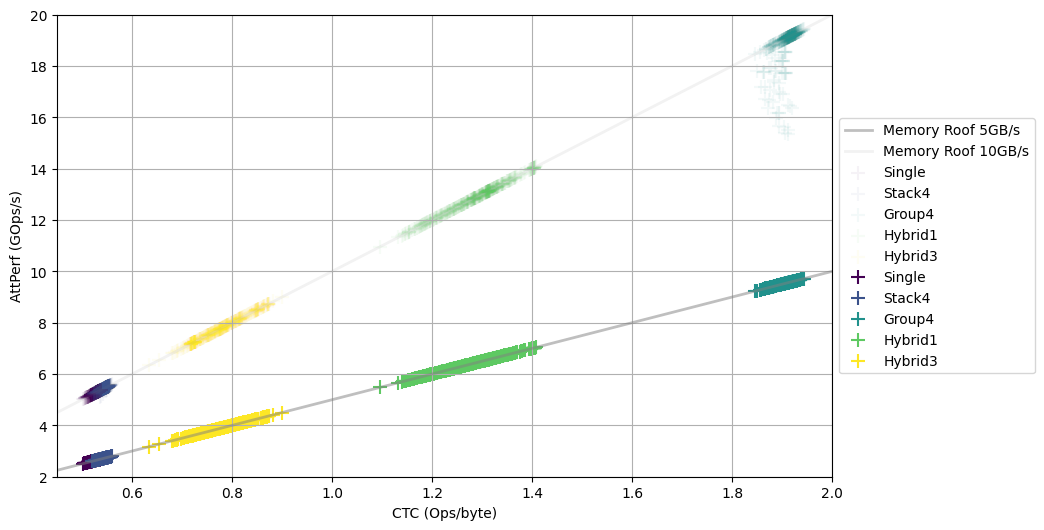

In [172]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 5 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 5GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_5GB['CTC (Ops/byte)'], single_5GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_5GB['CTC (Ops/byte)'], stack4_5GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_5GB['CTC (Ops/byte)'], group4_5GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_5GB['CTC (Ops/byte)'], hybrid1_5GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_5GB['CTC (Ops/byte)'], hybrid3_5GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
plt.ylim([2,20])
plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

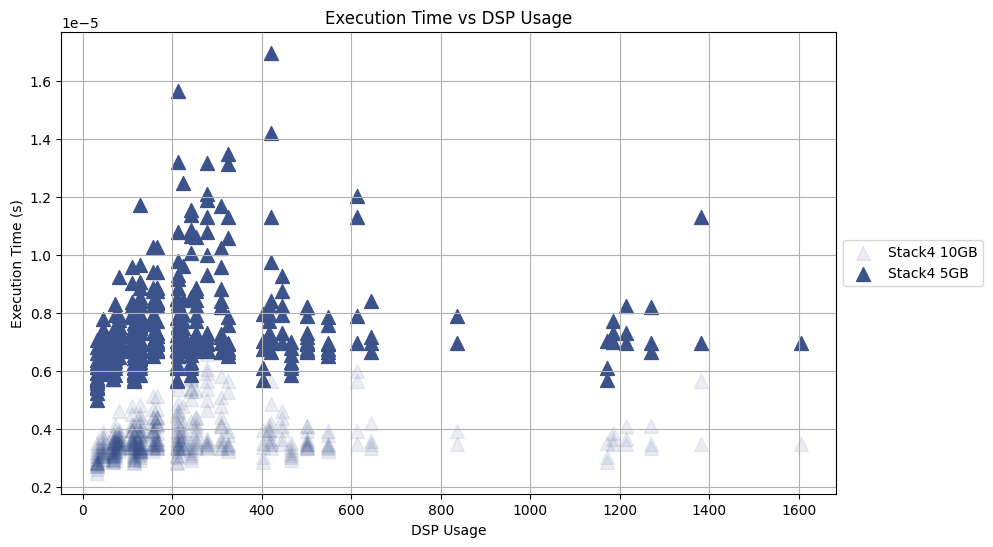

In [182]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.1)

plt.scatter(stack4_5GB['DSP Usage'], stack4_5GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 5GB')

# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

In [376]:
# update_results(df, clock_frequency, bandwidth, computation_roof):
baseline_20GB = update_results(baseline_10GB_dsp,400,20,50)
single_20GB = update_results(single_10GB_dsp,400,20,50)
stack4_20GB = update_results(stack4_10GB_dsp,400,20,50)
group4_20GB = update_results(group4_10GB_dsp,400,20,50)
hybrid1_20GB = update_results(hybrid1_10GB_dsp,400,20,50)
hybrid3_20GB = update_results(hybrid3_10GB_dsp,400,20,50)

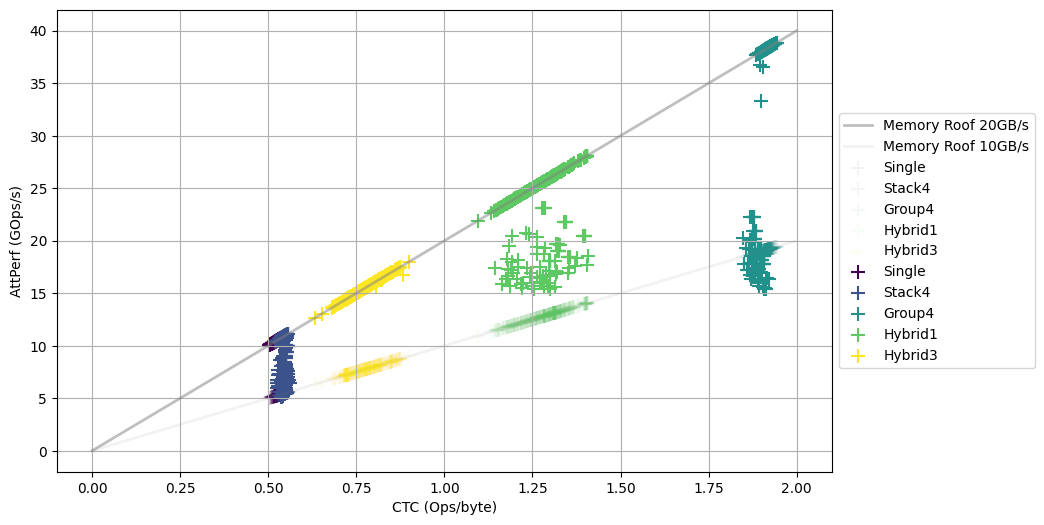

In [191]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 20 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 20GB/s',color='gray',alpha=0.5, linewidth=2)

# Define the x range, which is usually small to keep the y-values manageable
x = np.linspace(0, 2, 4000)

# Calculate the corresponding y values based on the equation y = 4000000000 * x
y = 10 * x

# Create the plot
plt.plot(x, y, label='Memory Roof 10GB/s',color='gray',alpha=0.1, linewidth=2)


colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(single_10GB_dsp['CTC (Ops/byte)'], single_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single', alpha=0.05)

plt.scatter(stack4_10GB_dsp['CTC (Ops/byte)'], stack4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4', alpha=0.05)

plt.scatter(group4_10GB_dsp['CTC (Ops/byte)'], group4_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4', alpha=0.05)
            
plt.scatter(hybrid1_10GB_dsp['CTC (Ops/byte)'], hybrid1_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1', alpha=0.05)

plt.scatter(hybrid3_10GB_dsp['CTC (Ops/byte)'], hybrid3_10GB_dsp['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3', alpha=0.05)

plt.scatter(single_20GB['CTC (Ops/byte)'], single_20GB['AttPerf (GOps/s)'],
            color=colors[0], marker='+', s=100, label='Single')

plt.scatter(stack4_20GB['CTC (Ops/byte)'], stack4_20GB['AttPerf (GOps/s)'],
            color=colors[1], marker='+', s=100, label='Stack4')

plt.scatter(group4_20GB['CTC (Ops/byte)'], group4_20GB['AttPerf (GOps/s)'],
            color=colors[2], marker='+', s=100, label='Group4')
            
plt.scatter(hybrid1_20GB['CTC (Ops/byte)'], hybrid1_20GB['AttPerf (GOps/s)'],
            color=colors[3], marker='+', s=100, label='Hybrid1')

plt.scatter(hybrid3_20GB['CTC (Ops/byte)'], hybrid3_20GB['AttPerf (GOps/s)'],
            color=colors[4], marker='+', s=100, label='Hybrid3')

# Labeling the axes
plt.xlabel('CTC (Ops/byte)')
plt.ylabel('AttPerf (GOps/s)')
# plt.ylim([2,20])
# plt.xlim([0.45,2])

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()

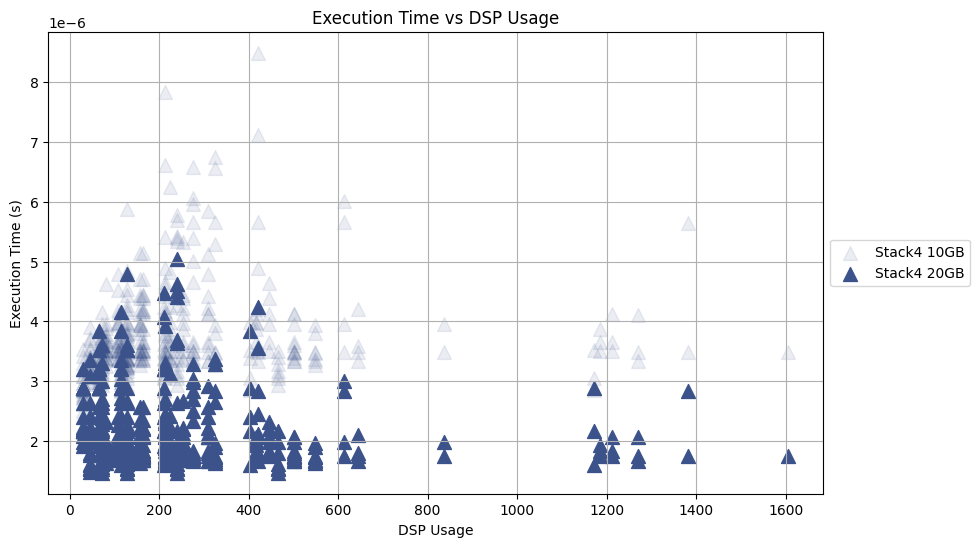

In [195]:
# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, 5))

plt.scatter(stack4_10GB_dsp['DSP Usage'], stack4_10GB_dsp['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 10GB',alpha=0.1)

plt.scatter(stack4_20GB['DSP Usage'], stack4_20GB['Execution Time (s)'],
            color=colors[1], marker='^', s=100, label='Stack4 20GB')

            
# Labeling the axes
plt.title('Execution Time vs DSP Usage')
plt.xlabel('DSP Usage')
plt.ylabel('Execution Time (s)')

# Add a legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

# Show the plot
plt.show()